In [ ]:
# CSV 파일 불러오기
# for vs code
file_path1 = 'data/Meteorological_2019_01.csv'
file_path2 = 'data/서울시_대기질_2019_01.csv'
xtest_path = 'data/Meteorological_2020_01.csv'
ytest_path = 'data/서울시_대기질_2020_01.csv'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# CSV 파일 불러오기
# for google colab
file_path1 = '/content/drive/MyDrive/2024-2학기_연구참여/data/Meteorological_2019_01.csv'
file_path2 = '/content/drive/MyDrive/2024-2학기_연구참여/data/서울시_대기질_2019_01.csv'
xtest_path = '/content/drive/MyDrive/2024-2학기_연구참여/data/Meteorological_2020_01.csv'
ytest_path = '/content/drive/MyDrive/2024-2학기_연구참여/data/서울시_대기질_2020_01.csv'

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv3D, MaxPooling3D
from sklearn.model_selection import train_test_split

In [4]:
# 'Meteorological data' 측정 지역의 위도와 경도 정보
met_regions_data = {
    'region': ['강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문', '중랑', '기상청', '마포', '서대문', '광진',
               '성북', '용산', '은평', '금천', '한강', '중구', '성동', '구로', '강북*', '남현', '관악', '영등포', '현충원'],
    'latitude': [37.49794, 37.47650, 37.53010, 37.51456, 37.55095, 37.51656, 37.66877, 37.65526, 37.57491, 37.59508, 37.56556,
                 37.56632, 37.57655, 37.53865, 37.58968, 37.53110, 37.60277, 37.45686, 37.52770, 37.56382, 37.56351, 37.49543,
                 37.646995, 37.46769, 37.47808, 37.52667, 37.50001],
    'longitude': [127.02761, 127.03250, 127.12587, 127.10662, 126.84953, 126.86658, 127.04744, 127.07712, 127.03963, 127.09368, 126.96691,
                  126.90131, 126.93784, 127.08237, 127.01667, 126.97960, 126.93040, 126.89576, 126.99818, 126.99760, 127.03722, 126.88740,
                  127.01371, 126.95818, 126.95143, 126.89636, 126.97422]
}

# DataFrame 생성
met_regions_df = pd.DataFrame(met_regions_data)

# '서울시 대기질 데이터' 각 구의 위도와 경도 정보
air_regions_data = {
    'region': ['종로구', '용산구', '중구', '은평구', '서대문구', '마포구', '광진구', '노원구', '중랑구', '도봉구',
               '성북구', '성동구', '강북구', '동대문구', '동작구', '영등포구', '강서구', '관악구', '양천구', '구로구',
               '금천구', '강남구', '서초구', '강동구', '송파구'],
    'latitude': [37.573050, 37.531100, 37.563820, 37.602770, 37.576550, 37.566320, 37.538650, 37.655260, 37.595080, 37.668770,
                 37.589680, 37.563510, 37.646995, 37.574910, 37.512410, 37.526670, 37.550950, 37.478080, 37.516560, 37.495430,
                 37.456860, 37.497940, 37.476500, 37.530100, 37.514560],
    'longitude': [126.979340, 126.979600, 126.997600, 126.930400, 126.937840, 126.901310, 127.082370, 127.077120, 127.093680, 127.047440,
                  127.016670, 127.037220, 127.013710, 127.039630, 126.941040, 126.896360, 126.849530, 126.951430, 126.866580, 126.887400,
                  126.895760, 127.027610, 127.032500, 127.125870, 127.106620]
}

# DataFrame 생성
air_regions_df = pd.DataFrame(air_regions_data)

In [5]:
# 전처리1: CSV 파일 특정 column만 불러오기
def read_processing(f1, f2):
    df1 = pd.read_csv(f1, usecols=lambda column: column != '지점', encoding='cp949')
    df2 = pd.read_csv(f2, usecols = ['측정일시', '측정소명', '오존(ppm)'], encoding='cp949')
    df2 = df2[['측정소명', '측정일시', '오존(ppm)']]
    return df1, df2

# 전처리2: 날짜 및 시간 데이터 변형
def time_processing(df1, df2):
    # df1의 '일시' 컬럼을 datetime 형식으로 변환
    df1['일시'] = pd.to_datetime(df1['일시'])

    # df2의 '측정일시' 컬럼을 datetime 형식으로 변환
    df2['측정일시'] = pd.to_datetime(df2['측정일시'], format='%Y%m%d%H%M')

    # df2를 정렬 (인플레이스)
    df2.sort_values(by=['측정소명', '측정일시'], inplace=True)

    # 인덱스 재설정 (인플레이스)
    df2.reset_index(drop=True, inplace=True)


In [12]:
# ------------------------------------------------------------------
# 전처리3: 누락된 부분 interpolation
# ------------------------------------------------------------------
def interpol_processing(df):
    # 변수 설정
    expected_timesteps = 744
    specific_date = df.iloc[0]['일시']
    start_date = specific_date.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
    end_date = (start_date+MonthEnd(0)).replace(hour=23, minute=0, second=0, microsecond=0)
    print(start_date, end_date)

    # '지점명'별로 그룹화하여 '일시' 개수 세기
    grouped = df.groupby('지점명')['일시'].count()

    # 누락된 데이터 찾기
    missing_data = grouped[grouped < expected_timesteps]

    missing_rows_info = []

    for station in missing_data.index:
        station_data = df[df['지점명'] == station]

        # 전체 일시 범위 정의
        full_range = pd.date_range(start=start_date, end=end_date, freq='h')

        # 누락된 일시 찾기
        missing_dates = full_range.difference(station_data['일시'])

        for missing_date in missing_dates:
            missing_rows_info.append({'지점명': station, '일시': missing_date})

    # 누락된 데이터 복구를 위한 새로운 행 생성
    new_rows = []
    for missing_row in missing_rows_info:
        location = missing_row['지점명']
        date = missing_row['일시']
        temp_data = df[(df['지점명'] != location) & (df['일시'] == date)]
        tmp = temp_data['기온(°C)'].mean()

        new_rows.append({'지점명': location, '일시': date, '기온(°C)': tmp})

    # 모든 새로운 행을 한 번에 추가하여 복사 최소화
    if new_rows:
        df_new = pd.DataFrame(new_rows)
        df = pd.concat([df, df_new], ignore_index=True)

    # df를 정렬 (인플레이스)
    df.sort_values(by=['지점명', '일시'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [8]:
# 전처리4:'일시'를 '날짜'와 '시각'으로 분리
def t_split_processing(df1, df2):
    # df1의 '일시'를 '날짜'와 '시각'으로 분리
    df1['날짜'] = df1['일시'].dt.date
    df1['시각'] = df1['일시'].dt.time
    df1.drop(columns=['일시'], inplace=True)

    # df1의 컬럼 순서 재정렬
    df1 = df1[['지점명', '날짜', '시각', '기온(°C)']]

    # df2의 '측정일시'를 '날짜'와 '시각'으로 분리
    df2['날짜'] = df2['측정일시'].dt.date
    df2['시각'] = df2['측정일시'].dt.time
    df2.drop(columns=['측정일시'], inplace=True)

    # df2의 컬럼 순서 재정렬
    df2 = df2[['측정소명', '날짜', '시각', '오존(ppm)']]

In [9]:
# 전처리5: 매핑

# 각 위도와 경도를 그리드 좌표로 변환하는 함수
def latlon_to_grid(lat, lon, lat_min, lat_max, lon_min, lon_max, grid_size):
    # 위도와 경도를 32x32 그리드 좌표로 변환
    row = int((lat - lat_min) / (lat_max - lat_min) * (grid_size - 1))
    col = int((lon - lon_min) / (lon_max - lon_min) * (grid_size - 1))
    return row, col

def map_processing(df1, df2, grid_data, label_grid_data, time_stamp):
    # 서울시의 위도와 경도 범위 설정
    seoul_lat_min, seoul_lat_max = 37.4133, 37.7151  # 남북 경계 위도
    seoul_lon_min, seoul_lon_max = 126.7341, 127.2693  # 동서 경계 경도

    grid_size = 32
    time_size = 3
    n_day = len(df1['일시'].unique())

    # 기상 데이터 그리드 좌표 변환
    regions = met_regions_df['region'].unique()
    dates = df1['일시'].unique()

    for region in regions:
        lat = met_regions_df.loc[met_regions_df['region'] == region, 'latitude'].values[0]
        lon = met_regions_df.loc[met_regions_df['region'] == region, 'longitude'].values[0]
        grid_row, grid_col = latlon_to_grid(lat, lon, seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max, grid_size)
        met_sub_data = df1.loc[df1['지점명'] == region]

        # 시각별 데이터 할당
        # 0번째 시각
        grid_data[0, 0, grid_row, grid_col, 0] = met_sub_data.iloc[0]['기온(°C)']
        grid_data[0, 1, grid_row, grid_col, 0] = met_sub_data.iloc[0]['기온(°C)']
        grid_data[0, 2, grid_row, grid_col, 0] = met_sub_data.iloc[0]['기온(°C)']
        # 1번째 시각
        grid_data[1, 0, grid_row, grid_col, 0] = met_sub_data.iloc[0]['기온(°C)']
        grid_data[1, 1, grid_row, grid_col, 0] = met_sub_data.iloc[1]['기온(°C)']
        grid_data[1, 2, grid_row, grid_col, 0] = met_sub_data.iloc[1]['기온(°C)']
        # 2번째 시각
        grid_data[2, 0, grid_row, grid_col, 0] = met_sub_data.iloc[0]['기온(°C)']
        grid_data[2, 1, grid_row, grid_col, 0] = met_sub_data.iloc[1]['기온(°C)']
        grid_data[2, 2, grid_row, grid_col, 0] = met_sub_data.iloc[2]['기온(°C)']

        #3번째~n_day-1까지 시각
        for date_index, date in enumerate(dates):
            if(date_index == n_day - time_size):
                break
            i_data = date_index+time_size # 3개의 시간대로 1개의 시간예측
            grid_data[i_data, 0:time_size, grid_row, grid_col, 0] = met_sub_data.iloc[date_index:date_index+time_size]['기온(°C)']


    # 오염물질 농도 매핑
    label_regions = air_regions_df['region'].unique()
    label_dates = df2['측정일시'].unique()

    for region in label_regions:
        lat = air_regions_df.loc[air_regions_df['region'] == region, 'latitude'].values[0]
        lon = air_regions_df.loc[air_regions_df['region'] == region, 'longitude'].values[0]
        l_grid_row, l_grid_col = latlon_to_grid(lat, lon, seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max, grid_size)
        air_sub_data = df2.loc[df2['측정소명']==region]

        # 시각별 데이터 할당
        for date_index, date in enumerate(label_dates):
            i_data = date_index
            label_grid_data[i_data, 0, l_grid_row, l_grid_col, 0] = air_sub_data.iloc[date_index]['오존(ppm)']
            time_stamp[i_data] = date # 현재 기록되는 오존값이 어느 시점의 오존 값인지 기록


In [13]:
for i in range(1, 2):
    # 변수 초기화
    time_size = 3
    grid_size = 32
    grid_data = np.zeros((744, time_size, grid_size, grid_size, 1))
    label_grid_data = np.zeros((744, 1, grid_size, grid_size, 1))
    time_stamp = np.empty(744, dtype='datetime64[m]')
    # file_path1 = f'data/Meteorological_20{i+18}_01.csv'
    # file_path2 = f'data/서울시_대기질_20{i+18}_01.csv'

    # Data PreProcessing
    met_data, air_quality_data = read_processing(file_path1, file_path2)
    time_processing(met_data, air_quality_data)
    met_data = interpol_processing(met_data)
    # t_split_processing(met_data, air_quality_data)
    map_processing(met_data, air_quality_data, grid_data, label_grid_data, time_stamp)

    # train, test split
    label_grid_data = label_grid_data.reshape(label_grid_data.shape[0],-1)
    xtrain, xvalid, ytrain, yvalid = train_test_split(
        grid_data, label_grid_data, train_size=0.7, test_size=0.3, random_state=99
        )

2019-01-01 00:00:00 2019-01-31 23:00:00


In [14]:
# loading test_data
te_grid_data = np.zeros((744, time_size, grid_size, grid_size, 1))
te_label_grid_data = np.zeros((744, 1, grid_size, grid_size, 1))
te_time_stamp = np.empty(744, dtype='datetime64[m]')

# Data PreProcessing
te_met_data, te_air_quality_data = read_processing(xtest_path, ytest_path)
time_processing(te_met_data, te_air_quality_data)
te_met_data = interpol_processing(te_met_data)
# t_split_processing(te_met_data, te_air_quality_data)
map_processing(te_met_data, te_air_quality_data, te_grid_data, te_label_grid_data, te_time_stamp)

# save test_data
xtest = te_grid_data
ytest = te_label_grid_data.reshape(te_label_grid_data.shape[0], -1)


2020-01-01 00:00:00 2020-01-31 23:00:00


In [15]:
# 모델 적용
tf.random.set_seed(1234)

# 모델 생성
model = Sequential([
    Conv3D(32, kernel_size = (2,3,3), activation='relu', input_shape=(time_size,grid_size,grid_size,1)),
    MaxPooling3D(pool_size = (1,2,2)),
    Conv3D(64, kernel_size = (2,3,3), activation='relu'),
    MaxPooling3D(pool_size = (1,2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(32*32, activation = 'linear')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 모델 학습
model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=10, batch_size = 16)

# 모델 평가
loss = model.evaluate(xtest,ytest)
print(f"Loss: {loss}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - loss: 7.7596e-04 - mae: 0.0106 - val_loss: 3.9763e-06 - val_mae: 0.0011
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 3.0995e-06 - mae: 7.7160e-04 - val_loss: 2.4589e-06 - val_mae: 3.5747e-04
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 2.3584e-06 - mae: 3.1155e-04 - val_loss: 2.4265e-06 - val_mae: 2.3579e-04
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 2.3404e-06 - mae: 2.2661e-04 - val_loss: 2.4234e-06 - val_mae: 2.1451e-04
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 2.3431e-06 - mae: 2.1161e-04 - val_loss: 2.4219e-06 - val_mae: 2.1052e-04
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 2.3465e-06 - mae: 2.0901e-04 - val_loss: 2.4207e-06 - val_mae: 2.0988e-04
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 2.3494e-06 - mae: 2.0870e-04 - val_loss: 2.4196e-06 - val_mae: 2.0983e-04
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - loss: 2.3520e-06

In [16]:
# 모델 사용
Ozone_predict = model.predict(xtest)
Ozone_predict = Ozone_predict.reshape(-1, 32, 32)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [ ]:
print(time_stamp)

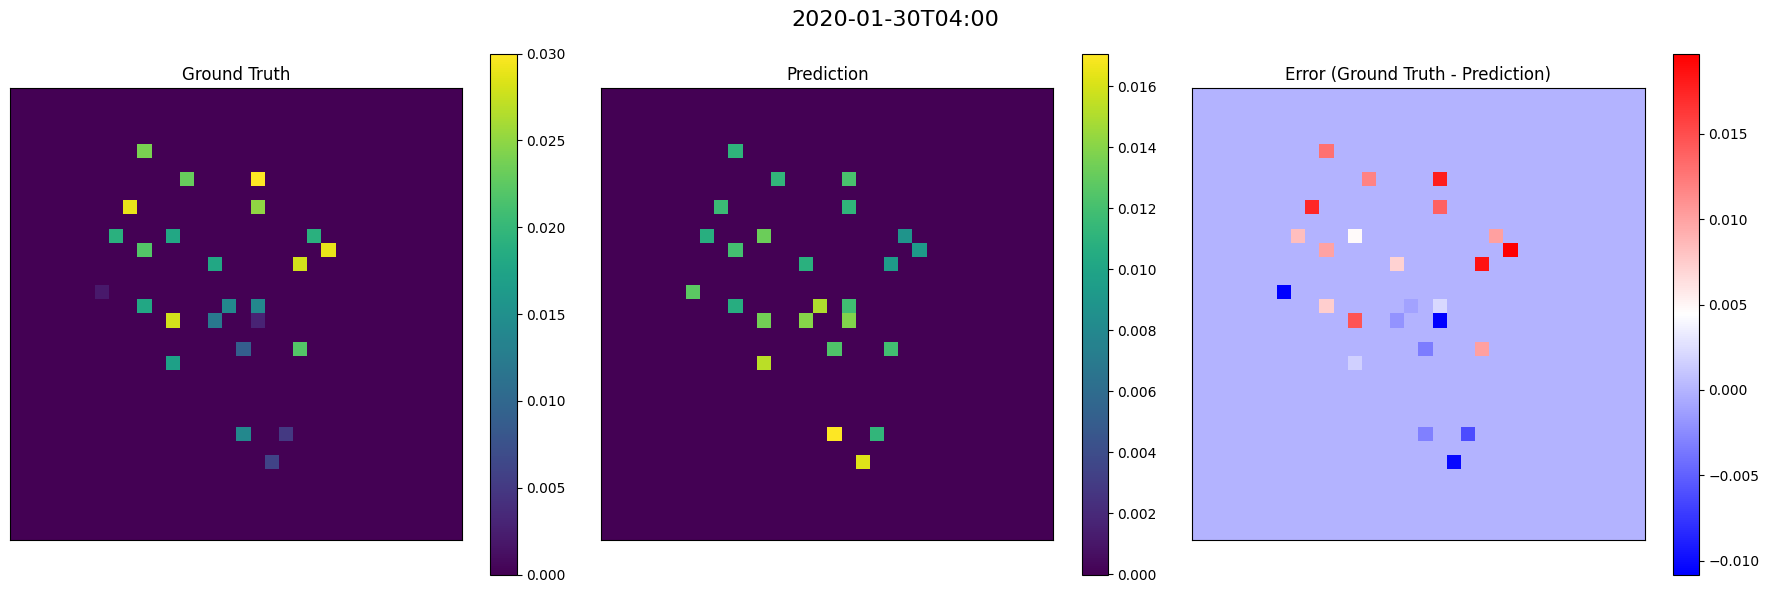

In [17]:
# 시각화 코드

# 이미 학습된 모델의 예측 결과와 실제 데이터를 가지고 있다고 가정합니다.
# Ozone_predict: 모델이 예측한 오존 농도 (shape: [744, 32, 32])
# label_grid_data: 실제 오존 농도 (shape: [744, 1, 32, 32, 1])

# 실제 데이터의 마지막 차원 제거 (차원 맞추기)
ground_truth = te_label_grid_data.reshape(-1, grid_size, grid_size)  # shape: [744, 32, 32]

# 에러 계산
error = ground_truth - Ozone_predict  # shape: [744, 32, 32]

# 시각화를 위한 함수 정의
def plot_ozone_maps(index):
    """
    특정 날짜와 시간에 대한 오존 농도의 실제값, 예측값, 에러를 시각화합니다.

    Parameters:
    - day_index (int): 0부터 30까지의 날짜 인덱스 (0은 1월 1일)
    - hour_index (int): 0부터 23까지의 시간 인덱스
    """
    # 데이터 추출
    gt = ground_truth[index]  # 실제 값
    pred = Ozone_predict[index]  # 예측 값
    err = error[index]  # 에러

    # 플롯 설정
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Ground Truth 시각화
    im1 = axes[0].imshow(gt, cmap='viridis', interpolation='nearest')
    axes[0].set_title('Ground Truth')
    plt.colorbar(im1, ax=axes[0])

    # Prediction 시각화
    im2 = axes[1].imshow(pred, cmap='viridis', interpolation='nearest')
    axes[1].set_title('Prediction')
    plt.colorbar(im2, ax=axes[1])

    # Error 시각화
    im3 = axes[2].imshow(err, cmap='bwr', interpolation='nearest')
    axes[2].set_title('Error (Ground Truth - Prediction)')
    plt.colorbar(im3, ax=axes[2])

    # 공통 설정
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    data_date = te_time_stamp[index].astype(str)

    # 전체 제목 설정
    fig.suptitle(data_date, fontsize=16)
    plt.tight_layout()
    plt.show()

# 예시: 1월 1일 0시 데이터를 시각화
plot_ozone_maps(index=700)